### Old Functions used from Assignment 1

### Implementation of Gillespie’s First Reaction Method

In [16]:
!pip install ndlib

import networkx as nx
import ndlib.models.epidemics as ep
import networkx as nx
import ndlib.models.ModelConfig as mc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 11.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00a 0:00:01


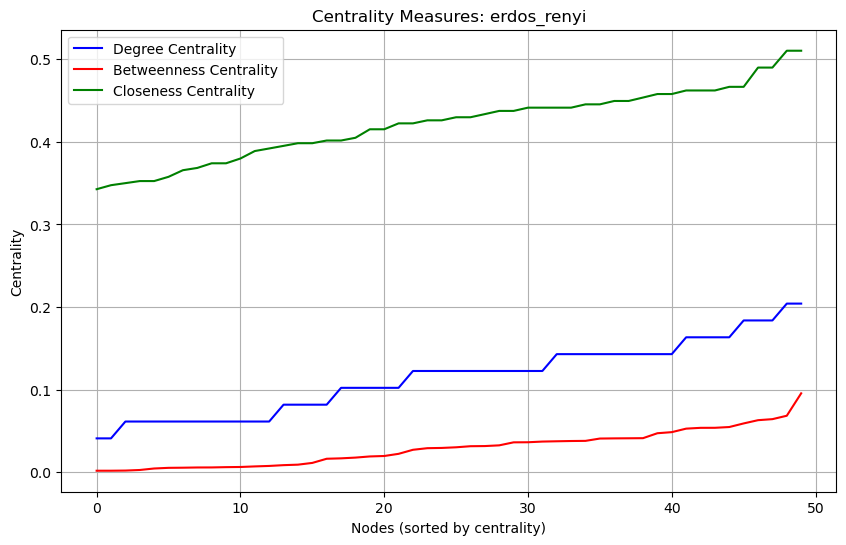

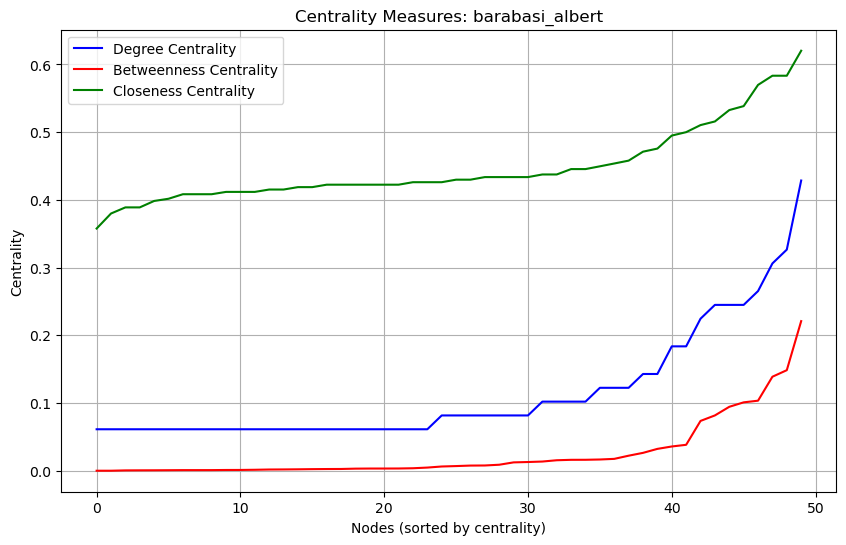

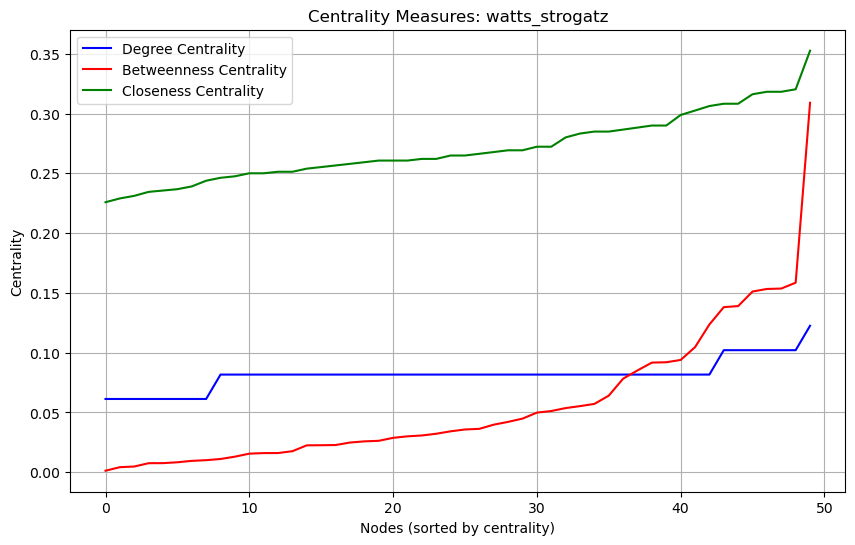

In [28]:
class NetworkModels:
    def __init__(self, g=None, graph_param=None):
        # Simply initialize without requiring parameters
        self.g = g

    def create_model_network(self, type, param_dict):
        match type:
            case 'erdos_renyi':
                n = param_dict.get('n')
                p = param_dict.get('p')
                if n is None or p is None:
                    raise ValueError(
                        f"Erdős-Rényi requires 'n' and 'p'. Provided: {param_dict}")
                return nx.erdos_renyi_graph(n, p)

            case 'barabasi_albert':
                n = param_dict.get('n')
                m = param_dict.get('m')
                if n is None or m is None:
                    raise ValueError(
                        f"Barabási-Albert requires 'n' and 'm'. Provided: {param_dict}")
                return nx.barabasi_albert_graph(n, m)

            case 'watts_strogatz':
                n = param_dict.get('n')
                k = param_dict.get('k')
                p = param_dict.get('p')
                if n is None or k is None or p is None:
                    raise ValueError(
                        f"Watts-Strogatz requires 'n', 'k', and 'p'. Provided: {param_dict}")
                return nx.watts_strogatz_graph(n, k, p)

            case _:
                raise ValueError(f"Unsupported graph type: {type}")

    def run_epidemic(self, numiter, beta, gamma, mu, fraction_infected):
        model = ep.SIRModel(self.g)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
        config.add_model_parameter('mu', mu)
        config.add_model_parameter("fraction_infected", fraction_infected)
        model.set_initial_status(config)

        iterations = model.iteration_bunch(numiter)
        trends = model.build_trends(iterations)

        return trends

    def compute_centrality_measures(self):
        degree_centrality = nx.degree_centrality(self.g)
        betweenness_centrality = nx.betweenness_centrality(self.g)
        closeness_centrality = nx.closeness_centrality(self.g)
        
        return degree_centrality, betweenness_centrality, closeness_centrality

    def plot_centrality_measures(self, centrality_data, title):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        degree_centrality = sorted(centrality_data['degree'].values())
        betweenness_centrality = sorted(centrality_data['betweenness'].values())
        closeness_centrality = sorted(centrality_data['closeness'].values())
        
        ax.plot(degree_centrality, label="Degree Centrality", color='blue')
        ax.plot(betweenness_centrality, label="Betweenness Centrality", color='red')
        ax.plot(closeness_centrality, label="Closeness Centrality", color='green')
        
        ax.set_xlabel("Nodes (sorted by centrality)")
        ax.set_ylabel("Centrality")
        ax.set_title(f"Centrality Measures: {title}")
        ax.legend()
        plt.grid(True)
        plt.show()

    def analyze_network_centrality(self, network_type, param_dict):
        # Create the network
        self.g = self.create_model_network(network_type, param_dict)
        
        # Compute centrality measures
        degree_centrality, betweenness_centrality, closeness_centrality = self.compute_centrality_measures()
        
        # Store centrality measures in a dictionary for plotting
        centrality_data = {
            'degree': degree_centrality,
            'betweenness': betweenness_centrality,
            'closeness': closeness_centrality
        }
        
        # Plot centrality measures
        self.plot_centrality_measures(centrality_data, network_type)


# Parameters for network generation
erdos_params = {"n": 50, "p": 0.1}
barabasi_params = {"n": 50, "m": 3}
watts_params = {"n": 50, "k": 4, "p": 0.1}

# Create the network model object
network_model = NetworkModels()

# Analyze and plot centrality measures for different networks
network_model.analyze_network_centrality('erdos_renyi', erdos_params)
network_model.analyze_network_centrality('barabasi_albert', barabasi_params)
network_model.analyze_network_centrality('watts_strogatz', watts_params)


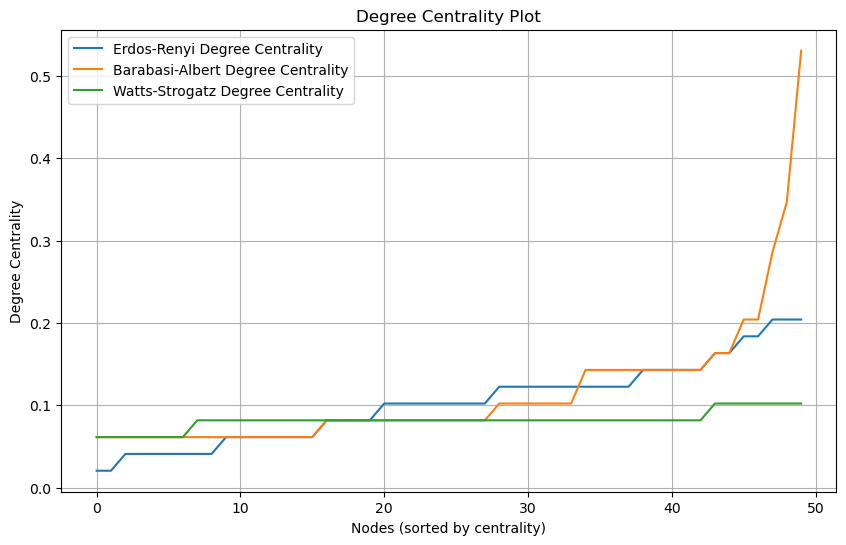

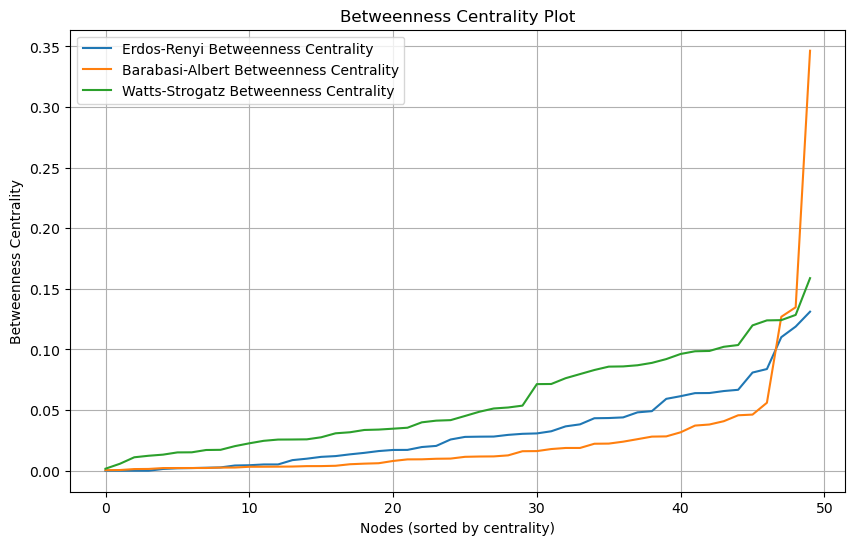

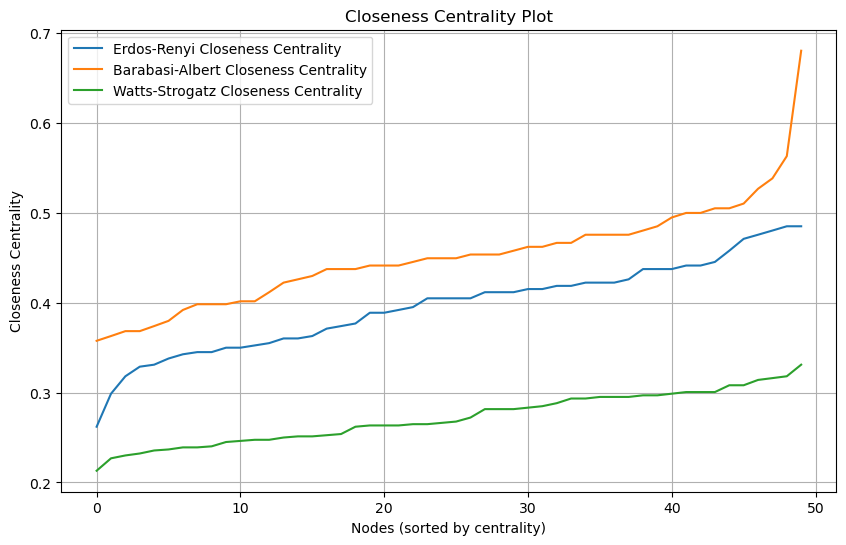

In [33]:
class NetworkModels:
    def __init__(self, g=None):
        self.g = g

    def create_model_network(self, type, param_dict):
        match type:
            case 'erdos_renyi':
                n = param_dict.get('n')
                p = param_dict.get('p')
                return nx.erdos_renyi_graph(n, p)

            case 'barabasi_albert':
                n = param_dict.get('n')
                m = param_dict.get('m')
                return nx.barabasi_albert_graph(n, m)

            case 'watts_strogatz':
                n = param_dict.get('n')
                k = param_dict.get('k')
                p = param_dict.get('p')
                return nx.watts_strogatz_graph(n, k, p)

            case _:
                raise ValueError(f"Unsupported graph type: {type}")

    def compute_centrality_measures(self):
        degree_centrality = nx.degree_centrality(self.g)
        betweenness_centrality = nx.betweenness_centrality(self.g)
        closeness_centrality = nx.closeness_centrality(self.g)
        
        return degree_centrality, betweenness_centrality, closeness_centrality

    # Plot Degree Centrality
    def plot_degree_centrality(self, centrality_data_dict):
        plt.figure(figsize=(10, 6))
        for network_type, centrality_data in centrality_data_dict.items():
            degree_centrality = sorted(centrality_data['degree'].values())
            plt.plot(degree_centrality, label=f"{network_type} Degree Centrality")
        
        plt.xlabel("Nodes (sorted by centrality)")
        plt.ylabel("Degree Centrality")
        plt.title("Degree Centrality Plot")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot Betweenness Centrality
    def plot_betweenness_centrality(self, centrality_data_dict):
        plt.figure(figsize=(10, 6))
        for network_type, centrality_data in centrality_data_dict.items():
            betweenness_centrality = sorted(centrality_data['betweenness'].values())
            plt.plot(betweenness_centrality, label=f"{network_type} Betweenness Centrality")
        
        plt.xlabel("Nodes (sorted by centrality)")
        plt.ylabel("Betweenness Centrality")
        plt.title("Betweenness Centrality Plot")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot Closeness Centrality
    def plot_closeness_centrality(self, centrality_data_dict):
        plt.figure(figsize=(10, 6))
        for network_type, centrality_data in centrality_data_dict.items():
            closeness_centrality = sorted(centrality_data['closeness'].values())
            plt.plot(closeness_centrality, label=f"{network_type} Closeness Centrality")
        
        plt.xlabel("Nodes (sorted by centrality)")
        plt.ylabel("Closeness Centrality")
        plt.title("Closeness Centrality Plot")
        plt.legend()
        plt.grid(True)
        plt.show()

    def analyze_network_centrality(self, network_type, param_dict):
        # Create the network
        self.g = self.create_model_network(network_type, param_dict)
        
        # Compute centrality measures
        degree_centrality, betweenness_centrality, closeness_centrality = self.compute_centrality_measures()
        
        # Return the centrality measures
        return {
            'degree': degree_centrality,
            'betweenness': betweenness_centrality,
            'closeness': closeness_centrality
        }

# Parameters for network generation
erdos_params = {"n": 50, "p": 0.1}
barabasi_params = {"n": 50, "m": 3}
watts_params = {"n": 50, "k": 4, "p": 0.1}

# Create the network model object
network_model = NetworkModels()

# Analyze and get centrality measures for each network
erdos_centrality = network_model.analyze_network_centrality('erdos_renyi', erdos_params)
barabasi_centrality = network_model.analyze_network_centrality('barabasi_albert', barabasi_params)
watts_centrality = network_model.analyze_network_centrality('watts_strogatz', watts_params)

# Combine all centrality measures into one dictionary
centrality_data_dict = {
    "Erdos-Renyi": erdos_centrality,
    "Barabasi-Albert": barabasi_centrality,
    "Watts-Strogatz": watts_centrality
}

# Plot Degree Centrality
network_model.plot_degree_centrality(centrality_data_dict)

# Plot Betweenness Centrality
network_model.plot_betweenness_centrality(centrality_data_dict)

# Plot Closeness Centrality
network_model.plot_closeness_centrality(centrality_data_dict)


In [18]:
import pandas as pd
import numpy as np
import networkx as nx

file_path = 'transmission_network.csv'
df = pd.read_csv(file_path, sep=';', header=None)
cleaned_df = df.iloc[1:, 1:].astype(float)
adj_matrix_cleaned = cleaned_df.values

G_cleaned = nx.from_numpy_array(np.array(adj_matrix_cleaned))

node_labels = df.iloc[1:, 0].astype(int).values
mapping_cleaned = {i: node_labels[i] for i in range(len(node_labels))}
G_cleaned = nx.relabel_nodes(G_cleaned, mapping_cleaned)




In [19]:
#NetworkModels(g = G_cleaned).run_epidemic(200, 1, 1/3, 1/20, 0.04)

[{'trends': {'node_count': {0: [360,
     284,
     95,
     29,
     20,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,
     19,

In [20]:
graph_erdos = ["erdos_renyi", {'n': 50 , "p" : 0.1}]
NetworkModels(graph_param = graph_erdos).run_epidemic(200, 1, 1/3, 1/20, 0.04)

[{'trends': {'node_count': {0: [48,
     41,
     18,
     2,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
     1,
  

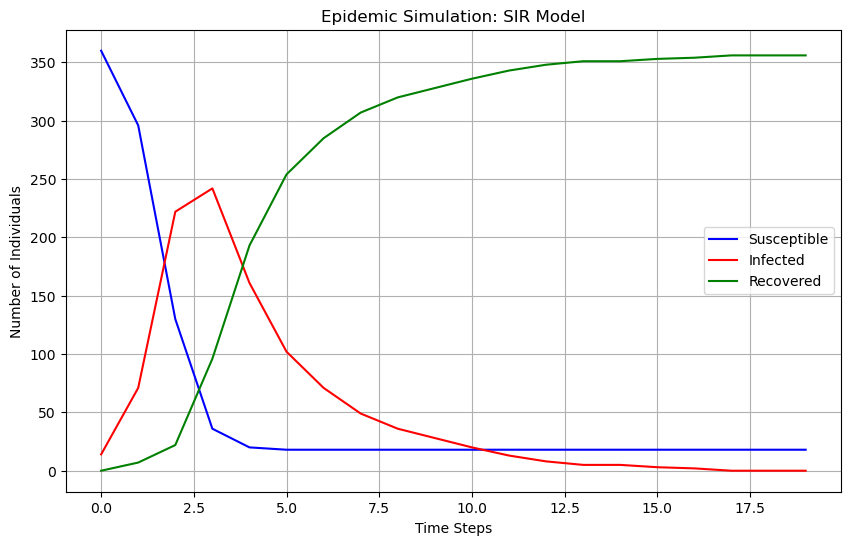

In [21]:
import matplotlib.pyplot as plt

def visualize_epidemic(trends):
    # Access the correct 'node_count' dictionary
    node_counts = trends['trends']['node_count']
    
    # Extract time series data for Susceptible (0), Infected (1), and Recovered (2)
    time_steps = range(len(node_counts[0]))  # Length of the time series
    susceptible = node_counts[0]  # 'S' count
    infected = node_counts[1]     # 'I' count
    recovered = node_counts.get(2, [0] * len(time_steps))  # 'R' count (ensure it's present)

    # Plot the epidemic trends over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, susceptible, label='Susceptible', color='blue')
    plt.plot(time_steps, infected, label='Infected', color='red')
    plt.plot(time_steps, recovered, label='Recovered', color='green')

    plt.xlabel('Time Steps')
    plt.ylabel('Number of Individuals')
    plt.title('Epidemic Simulation: SIR Model')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have run the run_epidemic function and stored the trends
trends = NetworkModels(g = G_cleaned).run_epidemic(20, 2, 1/3, 1/20, 0.04)[0]

# Visualize the trends
visualize_epidemic(trends)


In [22]:
trends = NetworkModels(g = G_cleaned).run_epidemic(200, 1, 1/3, 1/20, 0.04)
print(trends)

[{'trends': {'node_count': {0: [360, 284, 99, 23, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18], 1: [14, 83, 245, 236, 170, 107, 68, 48, 29, 23, 15, 7, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,